<img src='imgs/udesa_logo.png' alt='Logo de la Universidad de San Andrés' />


<h1 style="font-size: 3em; text-align: center;">Calibracion y rectificacion estereo</h1>

Este notebook tiene como objetivo realizar la **calibración estéreo** de un sistema de cámaras utilizando un conjunto de imágenes de calibración con un checkerboard.

In [1]:
import cv2
import pickle
import random
import glob, os
import calib
!pip install -qq git+https://github.com/udesa-vision/i308-utils.git
from i308_utils import imshow, show_images

<h2>1️⃣ Parámetros iniciales</h2>

Definimos los parámetros del patrón de calibración utilizado:
- `checkerboard`: cantidad de esquinas internas del patrón (filas, columnas).
- `square_size_mm`: tamaño real de cada cuadrado del patrón en milímetros.


In [2]:
checkerboard = (10, 7)  # (n_columns, n_rows) del patrón interno
square_size_mm = 24.2   # tamaño de cada cuadrado en milímetros

# Creamos los puntos del mundo del patrón en milímetros
checkerboard_world_points_mm = calib.board_points(checkerboard) * square_size_mm

<h2>2️⃣ Carga de imágenes de calibración estéreo</h2>

Utilizamos el dataset `calib/` para la calibracion (valgase al redundancia), asegurándonos de que cada imagen izquierda (`left`) tenga su correspondiente imagen derecha (`right`). Se ordenan numéricamente para asegurar que se emparejen bien.

In [3]:
directory = "datasets/budha_board/calib"
left_files_pattern = "*left*.jpg"
right_files_pattern = "*right*.jpg"

def numeric_sort(file_name):
    return int(file_name.split("_")[-1].split(".")[0])

left_file_names = sorted(
    glob.glob(os.path.join(directory, left_files_pattern)),
    key=numeric_sort
)

right_file_names = sorted(
    glob.glob(os.path.join(directory, right_files_pattern)),
    key=numeric_sort
)

# Verificamos que haya la misma cantidad de imágenes izquierda/derecha
num_left = len(left_file_names)
num_right = len(right_file_names)
if num_left != num_right:
    raise Exception(f"Cantidad de imágenes no coincide (left: {num_left}, right: {num_right})")

<h2>3️⃣ Detección de esquinas del checkerboard</h2>

Para cada par de imágenes, detectamos las esquinas del checkerboard. Refinamos las detecciones para mayor precisión subpíxel. Solo usamos los pares donde se detectaron las esquinas en **ambas** imágenes.

In [4]:
image_size = None
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)

world_points = []
left_images_points = []
right_images_points = []
left_images = []
right_images = []

for left_file, right_file in zip(left_file_names, right_file_names):
    print("Procesando:", os.path.basename(left_file), os.path.basename(right_file))

    left_image = cv2.imread(left_file, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_file, cv2.IMREAD_GRAYSCALE)

    # Verificamos tamaños
    if left_image.shape != right_image.shape:
        raise Exception("Las imágenes no tienen el mismo tamaño")

    if image_size is None:
        image_size = (left_image.shape[1], left_image.shape[0])

    found_left, corners_left = cv2.findChessboardCorners(left_image, checkerboard)
    found_right, corners_right = cv2.findChessboardCorners(right_image, checkerboard)

    if not (found_left and found_right):
        print("Checkerboard no se encontró en alguna de las imágenes")
        continue

    corners_left = cv2.cornerSubPix(left_image, corners_left, (7, 7), (-1, -1), criteria)
    corners_right = cv2.cornerSubPix(right_image, corners_right, (7, 7), (-1, -1), criteria)

    left_images_points.append(corners_left)
    right_images_points.append(corners_right)
    world_points.append(checkerboard_world_points_mm)
    left_images.append(left_image)
    right_images.append(right_image)

Procesando: calib_left_0.jpg calib_right_0.jpg
Procesando: calib_left_1.jpg calib_right_1.jpg
Procesando: calib_left_2.jpg calib_right_2.jpg
Procesando: calib_left_3.jpg calib_right_3.jpg
Procesando: calib_left_4.jpg calib_right_4.jpg
Procesando: calib_left_5.jpg calib_right_5.jpg
Procesando: calib_left_6.jpg calib_right_6.jpg
Procesando: calib_left_7.jpg calib_right_7.jpg
Procesando: calib_left_8.jpg calib_right_8.jpg
Procesando: calib_left_9.jpg calib_right_9.jpg
Procesando: calib_left_10.jpg calib_right_10.jpg
Procesando: calib_left_11.jpg calib_right_11.jpg
Procesando: calib_left_12.jpg calib_right_12.jpg
Procesando: calib_left_13.jpg calib_right_13.jpg
Procesando: calib_left_14.jpg calib_right_14.jpg
Procesando: calib_left_15.jpg calib_right_15.jpg
Procesando: calib_left_16.jpg calib_right_16.jpg
Procesando: calib_left_17.jpg calib_right_17.jpg
Procesando: calib_left_18.jpg calib_right_18.jpg
Procesando: calib_left_19.jpg calib_right_19.jpg
Procesando: calib_left_20.jpg calib_righ

graficamos algunos checkerboards y sus detecciones de corners para verificar que lo que encontró está ok:

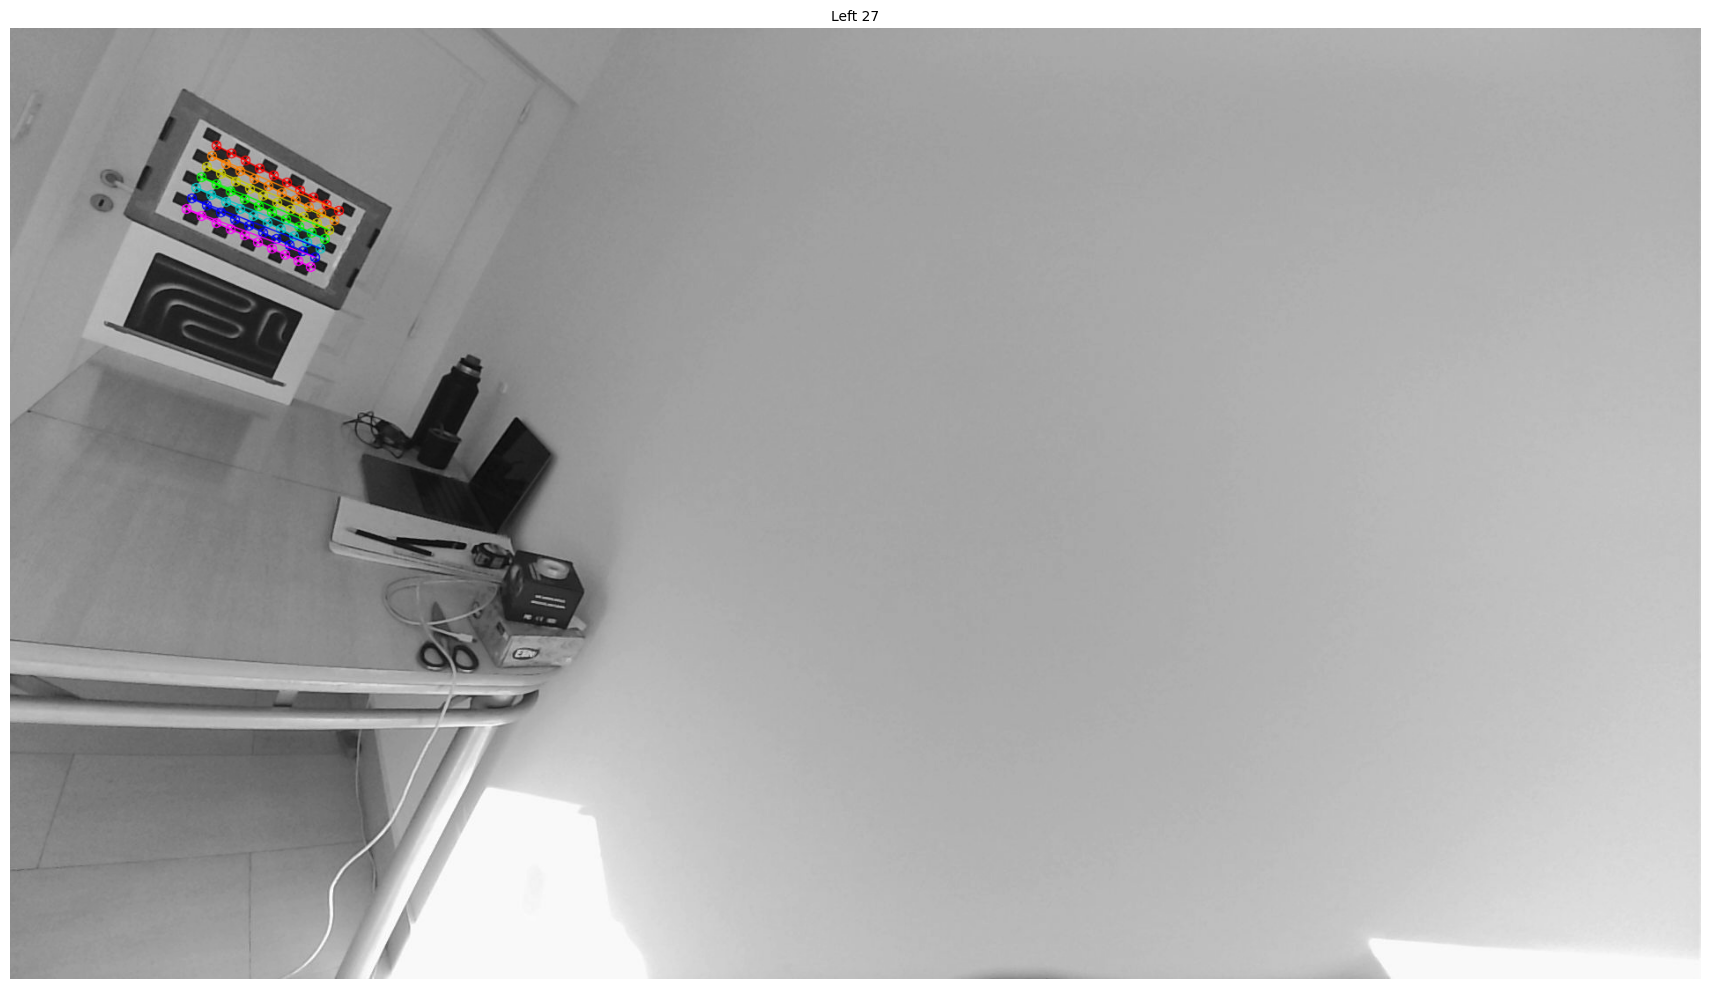

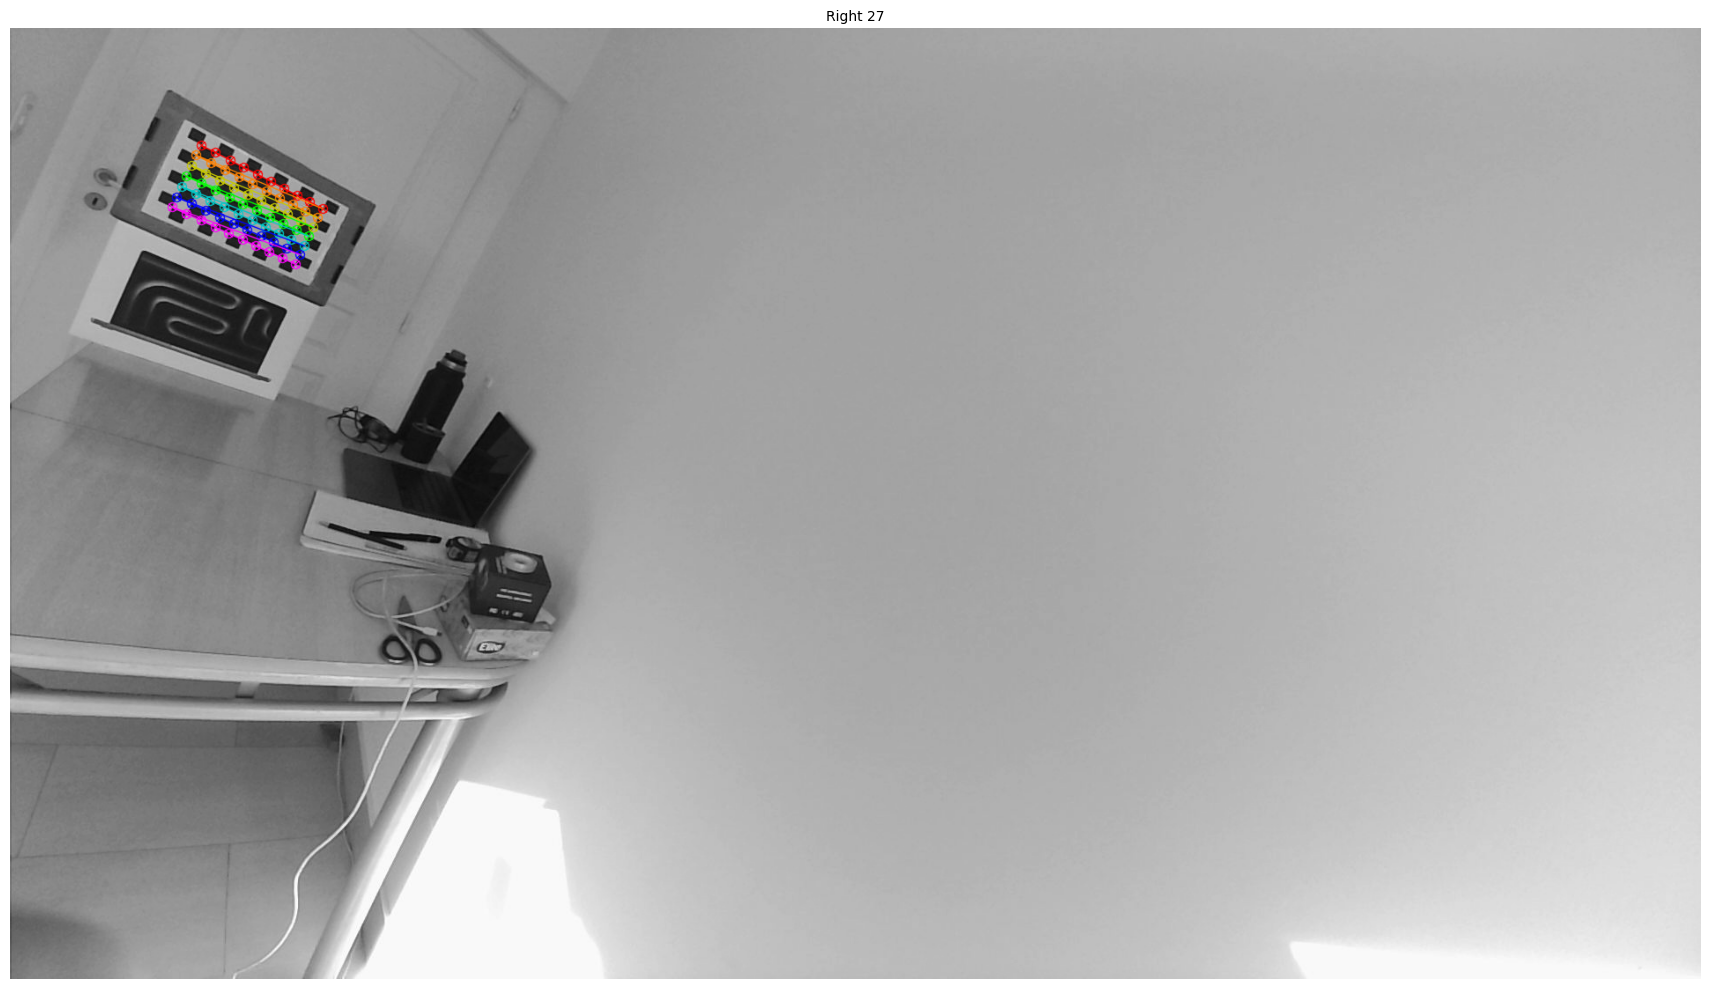

In [5]:
random.seed(0)
random_indices = random.sample(range(len(left_file_names)), 1)
left_images_with_corners = calib.draw_corners_on_images(
    [left_file_names[i] for i in random_indices],
    [left_images_points[i] for i in random_indices],
    checkerboard
)
right_images_with_corners = calib.draw_corners_on_images(
    [right_file_names[i] for i in random_indices],
    [right_images_points[i] for i in random_indices],
    checkerboard
)
show_images(
    left_images_with_corners,
    titles=[f"Left {i}" for i in random_indices],
    #cols=2,
    figsize=(20, 10)
)
show_images(
    right_images_with_corners,
    titles=[f"Right {i}" for i in random_indices],
    #cols=2,
    figsize=(20, 10)
)

<h2>4️⃣ Calibración estéreo con OpenCV </h2>

Usamos la función `cv2.stereoCalibrate` para estimar:
- Los **parámetros intrínsecos** de cada cámara (`K1`, `distCoeffs1`, `K2`, `distCoeffs2`).
- Los **parámetros extrínsecos** rotación y traslación relativa entre ambas cámaras (`R` y `t` que transforman puntos 3d del sistema de la cámara 1 (izquierda) al sistema de la cámara 2 (derecha)).
- Las **matrices esencial** y **fundamental**, (`E` y `F`) que describen la geometría epipolar entre las cámaras.

In [6]:
ret, K1, dist1, K2, dist2, R, T, E, F = cv2.stereoCalibrate(
    world_points,
    left_images_points,
    right_images_points,
    None, None, None, None,
    image_size,
    flags=0
)

from i308_utils import np_print
print("Matriz intrínseca cámara izquierda (K1):")
print(np_print(K1))
print("Distorsión cámara izquierda:", np_print(dist1))
print()
print("Matriz intrínseca cámara derecha (K2):")
print(np_print(K2))
print("Distorsión cámara derecha:", np_print(dist2))
print()
print("Rotación entre cámaras (R):")
print(np_print(R))
print("Traslación entre cámaras (T):")
print(np_print(T))
print("Matriz esencial (E):")
print(np_print(E))
print("Matriz fundamental (F):")
print(np_print(F))
print("Error de reproyección:", ret)

Matriz intrínseca cámara izquierda (K1):
np.array([
	[   600.569,	     0.000,	   963.433],
	[     0.000,	   600.775,	   548.961],
	[     0.000,	     0.000,	     1.000]
])
Distorsión cámara izquierda: np.array([
	[  0.004782,	 -0.023202,	 -0.000496,	  0.001601,	  0.003510]
])

Matriz intrínseca cámara derecha (K2):
np.array([
	[   600.059,	     0.000,	   960.028],
	[     0.000,	   599.822,	   535.499],
	[     0.000,	     0.000,	     1.000]
])
Distorsión cámara derecha: np.array([
	[  0.001949,	 -0.021507,	 -0.000628,	  0.000322,	  0.003217]
])

Rotación entre cámaras (R):
np.array([
	[     1.000,	    -0.000,	     0.010],
	[     0.000,	     1.000,	     0.010],
	[    -0.010,	    -0.010,	     1.000]
])
Traslación entre cámaras (T):
np.array([
	[-59.300782],
	[  0.584879],
	[ -0.325488]
])
Matriz esencial (E):
np.array([
	[    -0.006,	     0.320,	     0.588],
	[    -0.917,	    -0.571,	    59.292],
	[    -0.589,	   -59.298,	    -0.577]
])
Matriz fundamental (F):
np.array([
	[     0.000,	    

<h2>5️⃣ Rectificación estéreo y generación de mapas</h2>

Una vez obtenida la calibración estéreo, realizamos la **rectificación de las imágenes**. Este proceso transforma las imágenes izquierda y derecha de modo que los pares correspondientes estén alineados horizontalmente (es decir, que las líneas epipolares esten alineadas horizontalmente).

Esto facilita la búsqueda de correspondencias para el cálculo de disparidad y profundidad. Además, genera:
- nuevas matrices de proyección `P1`, `P2`,
- matriz de reproyección `Q`,
- mapas de remapeo (`map1x`, `map1y`, `map2x`, `map2y`)

In [7]:
# Rectificación estéreo
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K1, dist1, K2, dist2, image_size, R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0
)

# Mapas de remapeo (lookup maps para cv2.remap)
map1x, map1y = cv2.initUndistortRectifyMap(K1, dist1, R1, P1, image_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K2, dist2, R2, P2, image_size, cv2.CV_32FC1)

Aplicamos `cv2.remap` sobre un par de imágenes y verificamos que las líneas epipolares estén horizontalmente alineadas.

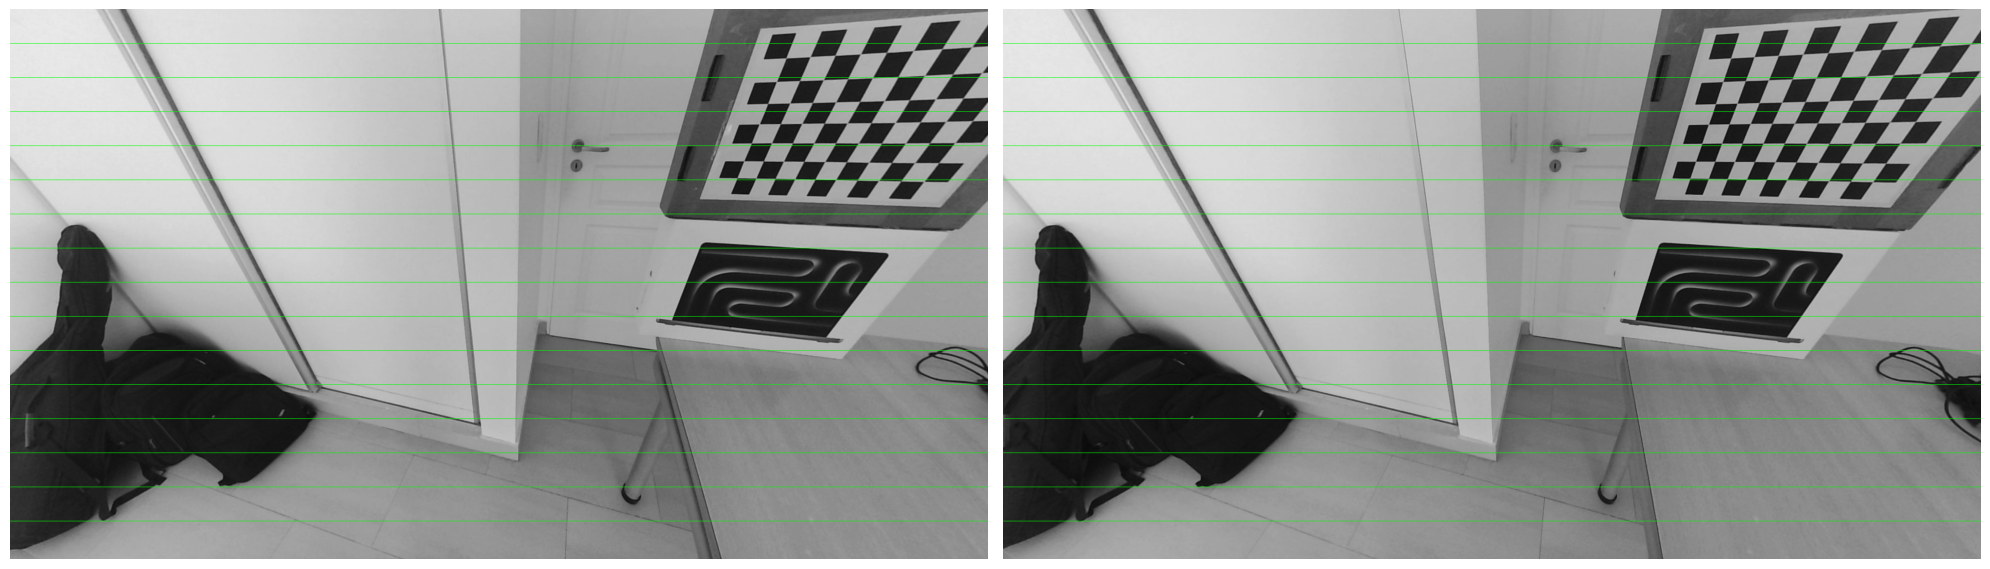

In [8]:
index = 0  # podés cambiar este índice si querés visualizar otro par

left_rectified = cv2.remap(left_images[index], map1x, map1y, cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_images[index], map2x, map2y, cv2.INTER_LINEAR)

# Dibujamos líneas horizontales para verificar la alineación epipolar
def draw_epipolar_lines(img, n_lines=15, color=(0,255,0)):
    h, w = img.shape
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    step = h // (n_lines + 1)
    for i in range(1, n_lines+1):
        y = i * step
        cv2.line(img_color, (0, y), (w, y), color, 1)
    return img_color

show_images(
    [draw_epipolar_lines(left_rectified), draw_epipolar_lines(right_rectified)],
    figsize=(20, 10)
)

Por ultimo, guardamos los parámetros necesarios para la reconstrucción posterior despues. Tambien, nos quedamos con todos los parametros intrínsecos y extrínsecos de la cámara izquierda (izquierda) y derecha (derecha) para usarlos en la rectificación estéreo. Asimismos, nos guardamos las matrices E y F para usarlas en la triangulacion de puntos 3D.

In [9]:
stereo_data = {
    "K1": K1, "dist1": dist1,
    "K2": K2, "dist2": dist2,
    "R": R, "T": T,
    "R1": R1, "R2": R2,
    "P1": P1, "P2": P2,
    "Q": Q,
    "map1x": map1x, "map1y": map1y,
    "map2x": map2x, "map2y": map2y,
    "image_size": image_size
}

with open("stereo_params.pkl", "wb") as f:
    pickle.dump(stereo_data, f)

print("Parámetros y mapas guardados en stereo_params.pkl")

Parámetros y mapas guardados en stereo_params.pkl
